Chapter 1 in the MATH 3050U text on Crystallization dynamics.  In particular, the formula (1.9) on page 11 requires the distribution of the volumes of the Voronoi cells associated with a uniform distribution of nucleation sites.  Formulate this as a 2-D not a 3-D problem (note (1.9) will change slightly) and then try to numerically compute what is now the distribution of area size for the Voronoi cells.  Once you know this, you can compute $\varphi(t)$ and see if you can get it to fit the data on page 18.

$ \displaystyle \varphi(t)=
\int\limits_{0}^{k t^{3}} s f{\left(s \right)}\, ds
+ k t^{3} \int\limits_{0}^{\infty} f{\left(s \right)}\, ds\quad(1.9)
\\\displaystyle
\varphi(t)=
\int\limits_{0}^{k t^{2}} s f{\left(s \right)}\, ds
+ k t^{2} \int\limits_{0}^{\infty} f{\left(s \right)}\, ds\quad(1.9) \text{ in 2-D}$

data on page 18:

`dd = [0.0802 0.011;...
0.1522 0.020;... 0.2955 0.044;...
0.3674 0.059;... 0.4391 0.081;...
0.5827 0.135;... 0.7259 0.250;... 0.8696 0.361;... 0.9842 0.476;... 1.0132 0.520;...
1.1564 0.690;... 1.2284 0.777;...
1.3000 0.841;... 1.3741 0.900;...
1.5049 0.962;... 1.6158 0.989;... 1.7305 0.9972];
t = dd(:,1); y = dd(:,2);`

or

$ \displaystyle \varphi(t)=
\int\limits_{0}^{k t^{3}} s f{\left(s \right)}\, ds
+ k t^{3} \int\limits_{0}^{\infty} f{\left(s \right)}\, ds$

with the empirical choice of

$\displaystyle f(s)= \beta s^{2} e^{- \gamma s^{2}},\beta=2\gamma^2=\frac{32}{\pi^2},k=.3193$

or

$ \displaystyle \varphi(t)=
\dfrac{1}{8\lambda }\left( 1-e^{-8\lambda kt^{3}}\right)$

when
$\displaystyle f(s)= 8\lambda e^{-8\lambda s}$ (systematic deriv)

what i want to simulate https://www.youtube.com/watch?v=hibmI6aGOso

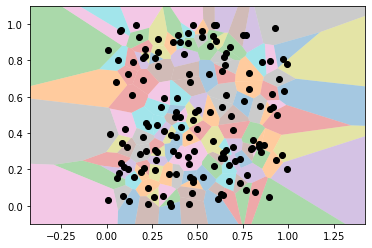

In [1]:
# from https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,ConvexHull,voronoi_plot_2d

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
# np.random.seed(1234)
np.random.seed(370)
points = np.random.rand(150, 2)
# points = np.array([[0, 0], [1, 1], [2, 0], [1, 2]]) # triang
# points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
#                    [2, 0], [2, 1], [2, 2]])
# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
'''
print "--"
print regions
print "--"
print vertices
'''

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

# plt.savefig('voro.png')
plt.show()

In [2]:
# voronoi_plot_2d(vor);

In [3]:
# from https://stackoverflow.com/questions/19634993/volume-of-voronoi-cell-python
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

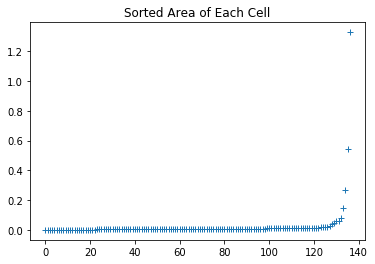

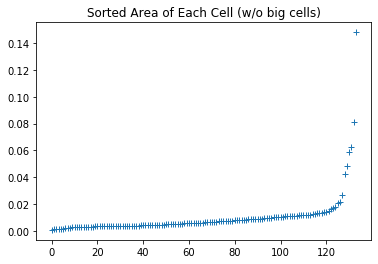

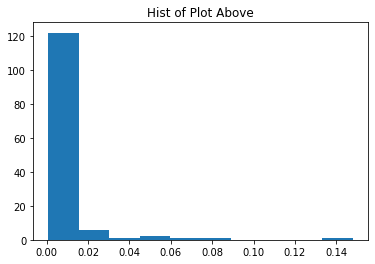

In [59]:
vol=voronoi_volumes(points)
vol=vol[vol!=np.inf]
# print(sorted(vol))
plt.title('Sorted Area of Each Cell')
plt.plot(sorted(vol)[:-1],'+');
plt.show()
plt.title('Sorted Area of Each Cell (w/o big cells)')
plt.plot(sorted(vol)[:-4],'+');
plt.show()
plt.title('Hist of Plot Above')
plt.hist(sorted(vol)[:-4]);

the distribution of the area size for the Voronoi cells seems to be poisson, so should I find $\lambda?$

Periodic boundary conditions:
https://pythoninchemistry.org/sim_and_scat/important_considerations/pbc.html